Installieren der Requirements:

In [36]:
#!pip install -r requirements.txt

# `waveform_generate()` Nachbau

Nachbau der Wellengenerierungsfunktion aus dem [Waveform-Modul](https://github.com/Fahradar/controller/src/waveform.h) der [Controller-Firmware](https://github.com/Fahradar/controller):
```C
waveform_generate(float x[2], float y, float speed, struct waveform_t *waveform_out);
```
Die Funktion zur Wellengenerierung wurde zu Visualiserungs- und Prototypingzwecken hier nachgebaut:

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def clampf(v, vmin, vmax):
    return max(vmin, min(v, vmax))

def float_to_u8(v):
    val = int(v * 255.0 + 0.5)
    return max(0, min(255, val))

def generate_waveform(x, y, speed):
    MIN_SAMPLES = 20
    MAX_SAMPLES = 40
    MIN_SPEED = 1.0
    MAX_SPEED = 50.0

    y_clamped = clampf(y, 1.0, 50.0)
    speed_clamped = clampf(speed, MIN_SPEED, MAX_SPEED)

    norm_y = (y_clamped - 1.0) / (50.0 - 1.0)
    sample_count = int(MAX_SAMPLES - (MAX_SAMPLES - MIN_SAMPLES) * (1.0 - norm_y) + 0.5)

    # Normalize speed & calculate the steepness k
    speed_norm = (speed_clamped - MIN_SPEED) / (MAX_SPEED - MIN_SPEED)
    k = 2.0 * (10 ** (speed_norm * 2))  # grows from 2 to 200

    # Left/right factor
    left_width = abs(x[0])
    right_width = abs(x[1])
    total_width = left_width + right_width if (left_width + right_width) > 0 else 1.0

    # Determine side presence
    has_left = x[0] < 0
    has_right = x[1] > 0

    left_factor = (left_width / total_width) if has_left else 0.0
    right_factor = (right_width / total_width) if has_right else 0.0

    # Generate normalized time vector and sigmoid values
    t_values = np.linspace(0, 1, sample_count)
    s_values = 1.0 / (1.0 + np.exp(-k * (t_values - 0.5)))

    # Normalize sigmoid so max(s_values) == 1.0
    s_values /= np.max(s_values)

    # Compute unscaled waveform
    left_raw = [left_factor * s for s in s_values]
    right_raw = [right_factor * s for s in s_values]

    # Compute global max of both channels
    max_val = max(max(left_raw), max(right_raw), 1e-5)  # avoid divide-by-zero

    # Normalize to full 255 amplitude if y is close
    scaling = (50.0 - y_clamped) / (50.0 - 10.0)
    scale = 255 * scaling / max_val

    # Scale
    left_samples = [int(v * scale + 1.0 + 0.5) for v in left_raw]
    right_samples = [int(v * scale + 1.0 + 0.5) for v in right_raw]

    return t_values, left_samples, right_samples

def plot_map_view(ax, x, y, label=None):
    x0, x1 = x
    ax.hlines(y, x0, x1, color='tab:grey', linewidth=4, label=label)
    ax.plot(x0, y, 'o', color='tab:blue')    # dot for left curve
    ax.plot(x1, y, 'o', color='tab:orange')   # dot for right curve
    #ax.plot([x0, x1], [y, y], 'o')
    ax.plot(0, 0, 'ro')
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 55)
    ax.invert_yaxis()  # flip y-axis so 0 is bottom, 50 is top
    ax.set_xlabel("Horizontale Position [m]")
    ax.set_ylabel("Distanz [m]")
    ax.set_title("Positionskarte")
    ax.grid(True)
    if label:
        ax.legend().set_visible(False)

def plot_waveform_and_map(x, y, speed, label=None):
    t, left, right = generate_waveform(x, y, speed)

    sample_indices = list(range(len(t)))

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Waveform plot
    axs[0].plot(sample_indices, left, label="Links")
    axs[0].plot(sample_indices, right, label="Rechts")

    # Add red 'x' markers at each sample
    axs[0].scatter(sample_indices, left, marker='.', zorder=3)
    axs[0].scatter(sample_indices, right, marker='.', zorder=3)

    axs[0].set_title(f"Geschwindigkeit: {speed} km/h; Distanz: {y} m")
    axs[0].set_xlabel("Sample Index")
    axs[0].set_ylabel("Amplitude (0–255)")
    axs[0].legend()
    axs[0].set_ylim(0, 256)
    axs[0].grid(True)
    if label:
        axs[0].legend(loc="upper left")

    plot_map_view(axs[1], x, y, label=label)

    plt.tight_layout()
    plt.show()

plt.figure(figsize=(5, 5))

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

# Parameter für Wellenform

Die Generierung der Wellenform ist abhängig vom gesendeten Objekt;

```c
struct object_t {
    uint32_t id;
    float x[2];
    float y;
    float speed;
};
```
**Beispiel** möglicher Objektframe:

| ID `uint32_t` | x[1] `float` | x[2] `float` | y `float` | speed `float` |
|------------------|---------------|---------------|------------|------------------|
| 1407363635 | -0.41 | 1.87 | 36.34 | 15.27 |

| Bezeichnung | Beschreibung |
|-------------------|--------------------|
| ID | ID des Objekts |
| x[1] | Linke *"Grenze"* des Objekts, Wert auf x-Achse [m] |
| x[2] | Rechte *"Grenze"* des Objekts, Wert auf x-Achse [m] |
| y | Position/Abstand zum Radar, Wert auf y-Achse [m] |
| speed | Geschwindigkeit des Objekts [km/h] |

----
## Boundingbox
Die Boundingbox ist ein eindimensionales Fließkommazahlen-Array `x[2]`.
Hierbei ist `x[0]` die linke Grenze und `x[1]` die rechte Grenze des Objekts. Die Einheit
Die Werte befinden sich auf der x-Achse die hinter dem Fahrrad gezogen wird.

<br>
<div style="border: 1px solid #1976D2; padding: 10px; border-radius: 5px; background-color: #E8F1FA; margin-right: 200px; margin-left: 200px;">
    ℹ️: $x$ $\mapsto$ Skalierung der Amplitude auf der jeweiligen Seite.
</div>
<br>

In [51]:
x=[-0.8, 0.5]

----
## Entfernung
Die Entferneung `y` ist ein Fließkommawert der die Distanz zum Objekt angibt. Je höher die Distanz desto niedriger die *Basisamplitude* und desto höher die Anzahl der Samples. Bei geringer Distanz sinkt die Anzahl der Samples was in einer geringern
Gesammtdauer der Wellenform resultiert.

<br>
<div style="border: 1px solid #1976D2; padding: 10px; border-radius: 5px; background-color: #E8F1FA; margin-right: 200px; margin-left: 200px;">
    ℹ️: $y$ $\mapsto$ Skalierung allgemeine Amplitude & Anzahl der Samples.
</div>
<br>

In [52]:
y=12

----
## Geschwindigkeit
Die Geschwindigkeit `speed` wirkt sich direkt auf die Wellenform aus. Bei einer hohen Geschwindigkeit bildet sich annähernd eine Rechteckform, während bei einer mittleren Geschwindigkeit das typische 'S' der Sigmoidfunktion sichtbar wird. Bei niedriger Geschwindigkeit ähnelt die Wellenform einer Rampe. Grund hierfür ist das menschliche Empfinden von Wellen. Hierbei sind Rechteckwellen am intensivsten Wahrgenommen.

<br>
<div style="border: 1px solid #1976D2; padding: 10px; border-radius: 5px; background-color: #E8F1FA; margin-right: 200px; margin-left: 200px;">
    ℹ️: $speed$ $\mapsto$ Steigungfaktor der Sigmoidfunktion.
</div>
<br>

In [55]:
speed=23

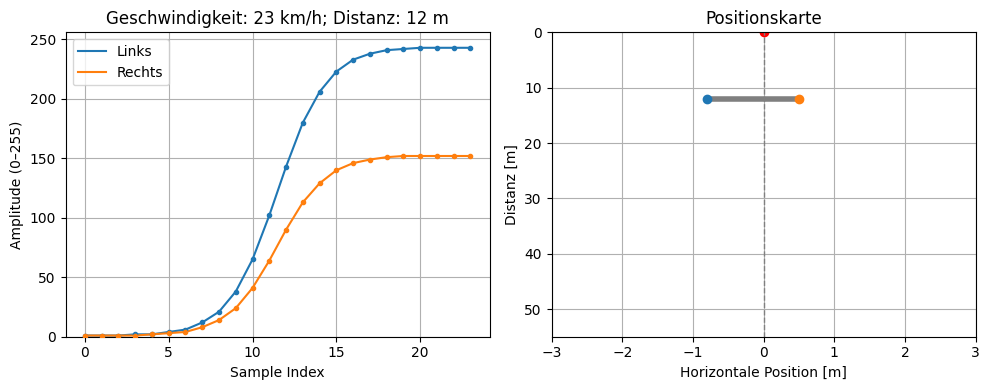

In [56]:
plot_waveform_and_map(x, y, speed)